In [1]:
import scanpy as sc
import scvi

[2020-07-29 19:34:16,146] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.


In [2]:
import scIB

In [9]:
import scvi.models

In [8]:
adata = sc.read('/storage/groups/ml01/workspace/scIB/simulations_1_1/sim1_1_norm.h5ad')

In [10]:
from scvi.dataset import AnnDatasetFromAnnData
from sklearn.preprocessing import LabelEncoder

In [11]:
import numpy as np

In [75]:
import imp
imp.reload(scanpy)

<module 'scanpy' from '/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/__init__.py'>

In [17]:
adata

AnnData object with n_obs × n_vars = 26668 × 18756 
    obs: 'barcode', 'batch', 'cell_type', 'cell_type_union', 'channel', 'log_counts', 'marker_gene', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sample_id', 'sex', 'size_factors', 'study', 'tissue'
    var: 'gene_ids-1-1'
    layers: 'counts'

In [61]:
le = LabelEncoder()
adata.obs['labels'] = le.fit_transform(adata.obs['Group'].values)

In [ ]:
le = LabelEncoder()
adata.obs['la'] = le.fit_transform(adata.obs['Group'].values)

In [32]:
net_adata = AnnDatasetFromAnnData(adata, batch_label='batch', class_label='labels')

[2020-07-29 15:48:49,661] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-29 15:48:49,663] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-29 15:48:49,823] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-29 15:48:49,995] INFO - scvi.dataset.dataset | Downsampled from 26668 to 26668 cells


In [37]:
net_adata.labels = adata.obs['labels']

In [39]:
net_adata.n_labels

107

In [28]:
def runScanvi(adata, batch, labels, hvg=None):
    # Use non-normalized (count) data for scvi!
    # Expects data only on HVGs
    
    scIB.utils.checkSanity(adata, batch, hvg)

    # Check for counts data layer
    if 'counts' not in adata.layers:
        raise TypeError('Adata does not contain a `counts` layer in `adata.layers[`counts`]`')

    from scvi.models import VAE, SCANVI
    from scvi.inference import AlternateSemiSupervisedTrainer, SemiSupervisedTrainer
    from sklearn.preprocessing import LabelEncoder
    from scvi.dataset import AnnDatasetFromAnnData

    # Defaults from SCVI github tutorials scanpy_pbmc3k and harmonization
    n_epochs=np.min([round((20000/adata.n_obs)*400), 400])
    n_latent=30
    n_hidden=128
    n_layers=2
    
    net_adata = adata.copy()
    net_adata.X = adata.layers['counts']
    del net_adata.layers['counts']
    # Ensure that the raw counts are not accidentally used
    del net_adata.raw # Note that this only works from anndata 0.7

    # Define batch indices
    le = LabelEncoder()
    net_adata.obs['batch_indices'] = le.fit_transform(net_adata.obs[batch].values)
    net_adata.obs['labels'] = le.fit_transform(net_adata.obs[labels].values)

    net_adata_out = AnnDatasetFromAnnData(net_adata)
    net_adata_out.labels = net_adata.obs['labels']

    scanvi = SCANVI(
        net_adata_out.nb_genes,
        reconstruction_loss='nb',
        n_batch=net_adata_out.n_batches,
        n_labels=net_adata_out.n_labels,
        #n_layers=n_layers,
        #n_latent=n_latent,
        #n_hidden=n_hidden,
    )

    trainer = SemiSupervisedTrainer(
        scanvi,
        net_adata_out,
        train_size=1.0,
        n_epochs_classifier=10,
        use_cuda=False,
    )
    
    #trainer.labelled_set = trainer.create_posterior()

    trainer.train(n_epochs=5)

    full = trainer.create_posterior(trainer.model, net_adata_out, indices=np.arange(len(net_adata_out)))
    latent, _, _ = full.sequential().get_latent()
    
    adata.obsm['X_emb'] = latent

    return adata


In [29]:
integrated2 = runScanvi(adata, 'Batch', 'Group')

[2020-07-29 23:46:45,592] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-07-29 23:46:46,323] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-29 23:46:46,325] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-29 23:46:46,696] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-29 23:46:47,023] INFO - scvi.dataset.dataset | Downsampled from 12097 to 12097 cells


training: 100%|██████████| 5/5 [01:41<00:00, 20.45s/it]


In [80]:
sc.write('scanvi_integrated.h5ad', integrated)

In [71]:
sc.pl.umap(integrated)

In [ ]:
scIB.pp.reduce_data(integrated2, use_rep='X_emb', pca=False)

HVG
Calculating 2000 HVGs for reduce_data.


In [77]:
import matplotlib.pyplot as plt

In [79]:
sc.pl.umap(adata)
plt.show()

In [3]:
integrated = sc.read_h5ad('scanvi_integrated.h5ad')

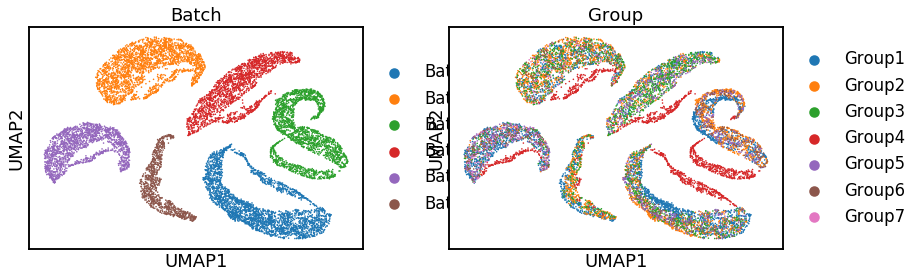

In [26]:
sc.pl.umap(integrated, color=['Batch', 'Group'])